In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import tensorflow

keras = tensorflow.keras

from collections import Counter

from sklearn.decomposition import NMF

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

In [34]:
data = pd.read_csv('data/src-data/transcripts_by_justice.csv')
decisions = pd.read_csv('data/src-data/decisions.csv', encoding='latin1')

In [44]:
dockets = data['docket'].unique()
new_df = pd.DataFrame()
ct = 0
for docket in dockets:
    ct += 1
    if ct % 100 == 0:
        print(ct)
    term = data[data['docket'] == docket]['term'].values[0]
    caseName = data[data['docket'] == docket]['caseName'].values[0]
    decidedBy = data[data['docket'] == docket]['decidedBy'].values[0]
    arguedOn = data[data['docket'] == docket]['arguedOn'].values[0]
    petitioner = data[data['docket'] == docket]['petitioner'].values[0]
    respondent = data[data['docket'] == docket]['respondent'].values[0]
    grantedOn = data[data['docket'] == docket]['grantedOn'].values[0]
    decidedOn = data[data['docket'] == docket]['decidedOn'].values[0]
    
    temp = data[data['docket'] == docket]
    text = ''
    for item in temp['text']:
        text += str(item) + ' '

    cleanText = ''
    for item in temp['cleanText']:
        cleanText += str(item) + ' '
                   
    new_df = new_df.append({'term' : term, 
                            'caseName' : caseName, 
                            'text' : text, 
                            'cleanText' : cleanText,
                            'decidedBy' : decidedBy,
                            'arguedOn' : arguedOn, 
                            'petitioner' : petitioner,
                            'respondent' : respondent,
                            'docket' : docket,
                            'grantedOn' : grantedOn, 
                            'decidedOn' : decidedOn},
                            ignore_index=True)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800


In [64]:
merged = pd.merge(new_df, decisions[['docket', 'partyWinning']].drop_duplicates('docket'), 
                  left_on=['docket'], right_on=['docket'])
merged = merged[merged['partyWinning'] != 2]

In [66]:
X = merged['cleanText'].fillna(' ').to_numpy()
y = merged['partyWinning'].to_numpy()

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [74]:
tfidf = TfidfVectorizer()
train_vec = tfidf.fit_transform(X_train)
test_vec = tfidf.transform(X_test)

smote = SMOTE()
train_vec, y_train = smote.fit_resample(train_vec, y_train)

In [76]:
model = SVC()
model.fit(train_vec, y_train)
y_pred = model.predict(test_vec)

In [77]:
print('Recall : %.2f' % recall_score(y_test, y_pred))
print('Precision : %.2f' % precision_score(y_test, y_pred))

Recall : 0.85
Precision : 0.59


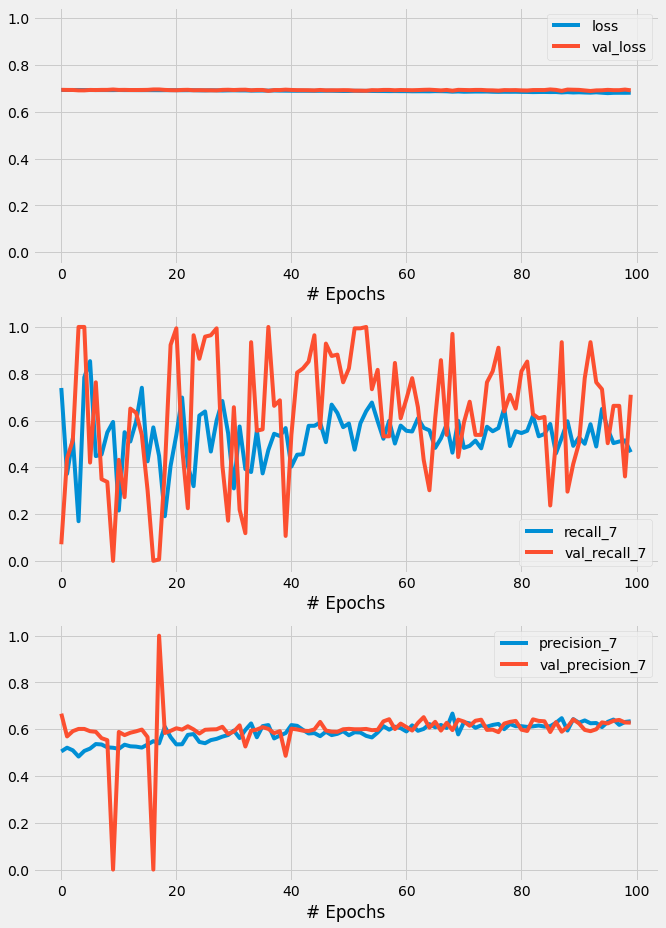

In [102]:
n_epochs=100

model = keras.Sequential()
model.add(keras.layers.Dense(units=8, 
                             input_shape=(train_vec.shape[1],), 
                             activation='relu'))
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=16,  
                             activation='relu'))
model.add(keras.layers.Dense(units=1, 
                             activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='SGD',
            metrics=[keras.metrics.Recall(), keras.metrics.Precision()])

hist = model.fit(train_vec.toarray(), y_train, batch_size=32, epochs=n_epochs, 
          validation_data=(test_vec.toarray(), y_test), verbose=0)

fig, ax = plt.subplots(3, 1, figsize=(10, 15))
metrics = ['loss', 'recall', 'precision']
for ax_, metric in zip(ax, metrics):
    keys = hist.history.keys()
    to_use = [key for key in keys if (metric in key)]
    ax_.plot(range(n_epochs), hist.history[to_use[0]], label=to_use[0])
    ax_.plot(range(n_epochs), hist.history[to_use[1]], label=to_use[1])
    ax_.set_ylim(-0.05, 1.05)
    ax_.set_xlabel('# Epochs')
    ax_.legend()

In [103]:
y_pred = model.predict(test_vec)
y_pred = np.round(y_pred).flatten()

In [104]:
print('Recall : %.2f' % recall_score(y_test, y_pred))
print('Precision : %.2f' % precision_score(y_test, y_pred))

Recall : 0.71
Precision : 0.63
